# Import Lib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import keras

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN
from keras.initializers import Constant
import keras.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import warnings
import string
import re
warnings.filterwarnings('ignore')
sns.set()

# Importing Data

In [ ]:
url = 'https://drive.google.com/file/d/1UCM8Q5pAXsceDgbXmCKvjtQB-w9S2DPi/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

In [ ]:
headlines = pd.read_json(path)
headlines.head(5)

,article_link,headline,news_category,is_sarcastic
0,https://www.dailysquib.co.uk/sci_tech/42337-th...,The Cummings and Goings of an Alien Visitor to...,rochdaleherald.co.uk,1
1,https://www.dailysquib.co.uk/sci_tech/41664-ne...,Neuralink: Monkey Playing Pong,rochdaleherald.co.uk,1
2,https://www.dailysquib.co.uk/sci_tech/41301-if...,"If You Care About the Planet, Forget Bitcoin, ...",rochdaleherald.co.uk,1
3,https://www.dailysquib.co.uk/sci_tech/41281-dw...,Dwayne ‘The Rock’ Johnson Amazes MIT Students ...,rochdaleherald.co.uk,1
4,https://www.dailysquib.co.uk/sci_tech/40864-so...,Social Media Monopolies Should Be Viewed as Ex...,rochdaleherald.co.uk,1


In [ ]:
headlines.shape

(13938, 4)

In [ ]:
# count null
headlines.isnull().sum()

article_link     0
headline         0
news_category    0
is_sarcastic     0
dtype: int64

In [ ]:
headlines.describe(include='object')

,article_link,headline,news_category
count,13938,13938,13938
unique,1012,1012,66
top,https://www.foxbusiness.com/money/defer-person...,What to know if you defer your personal loan,https://www.nbcnews.com/business/
freq,211,211,3175


In [ ]:
len(headlines[headlines.headline.duplicated()])

12926

dataset có 12926 headlines trùng nhau.
Những headlines trùng lặp này có khác class không?

In [ ]:
count_of_target = 0
for target in headlines.groupby(headlines.headline).is_sarcastic.agg(list):
    if(len(set(list(target))) != 1):
        count_of_target += 1
print(count_of_target)

0


May mắn là không có vì nếu trùng lặp nhưng khác class gây ra sự 'bối rối' cho mô hình

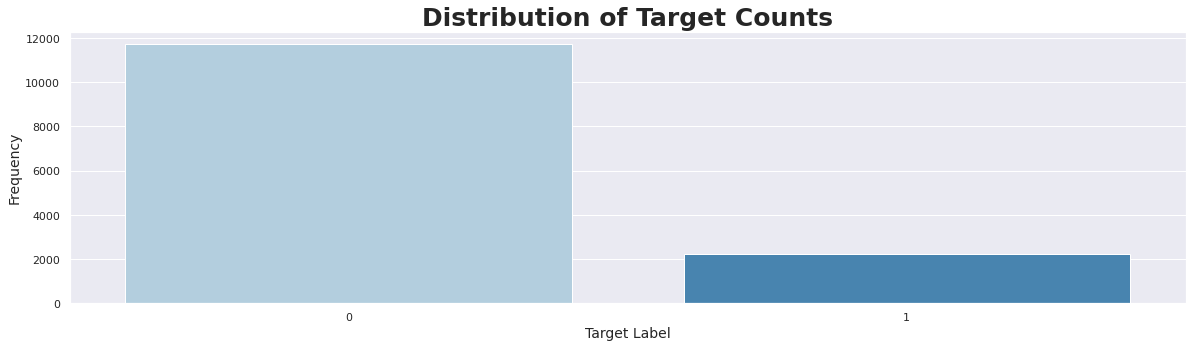

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(headlines.is_sarcastic, palette='Blues')
plt.title("Distribution of Target Counts", size=25, weight='bold')
plt.xlabel("Target Label", size=14)
plt.ylabel("Frequency", size=14)
plt.show()

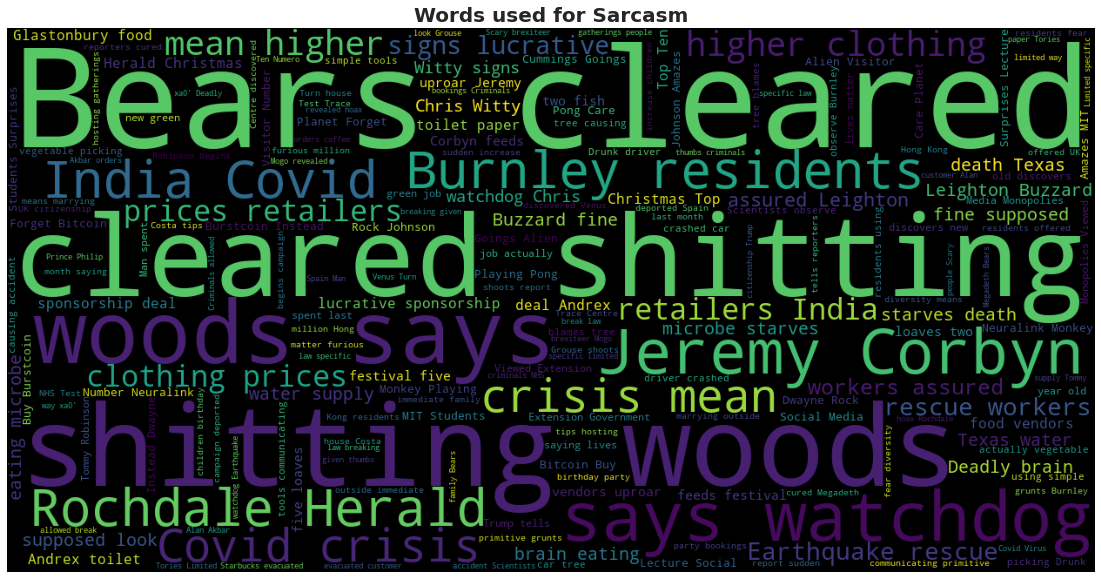

In [ ]:
all_keywords = " ".join(line for line in headlines[headlines.is_sarcastic==1].headline)
word_cloud= WordCloud(width=1250, height=625, max_font_size=350, 
                      random_state=42).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for Sarcasm", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

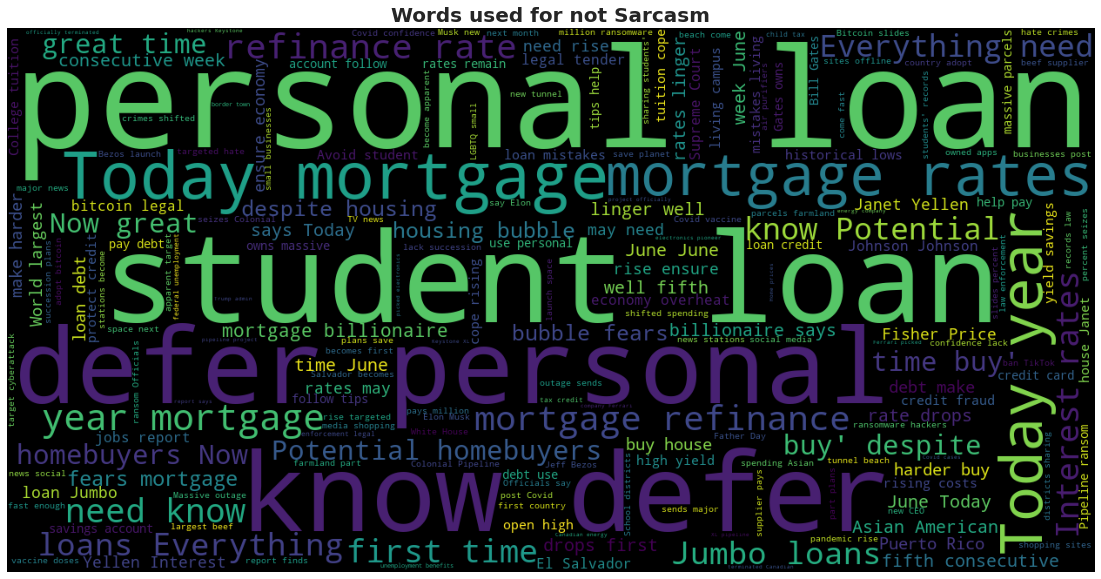

In [ ]:
all_keywords = " ".join(line for line in headlines[headlines.is_sarcastic==0].headline)
word_cloud= WordCloud(width=1250, height=625, max_font_size=350, 
                      random_state=42).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for not Sarcasm", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

#Clean data

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def clean_headline(headline):
    STOPWORDS = set(stopwords.words("english"))
    headline = headline.lower()
    headline = " ".join(word for word in headline.split() if word not in STOPWORDS)
    headline = "".join(word for word in headline if word not in set(string.punctuation))
    return headline

headlines.headline = headlines.headline.apply(clean_headline)
headlines.drop('article_link', inplace=True, axis=1)
headlines.head()

,headline,news_category,is_sarcastic
0,cummings goings alien visitor number 10,rochdaleherald.co.uk,1
1,neuralink monkey playing pong,rochdaleherald.co.uk,1
2,care planet forget bitcoin buy burstcoin instead,rochdaleherald.co.uk,1
3,dwayne ‘the rock’ johnson amazes mit students ...,rochdaleherald.co.uk,1
4,social media monopolies viewed extension gover...,rochdaleherald.co.uk,1


#Preprocessing

Sử dụng GLoVe Embeddings vì chúng đại diện cho các từ sử dụng ngữ cảnh và học các **word vector** sao cho **tích** của chúng bằng logarit của xác suất đồng xuất hiện của các từ.
Link: https://www.kaggle.com/shivam017arora/imdb-sentiment-analysis

In [ ]:
corpus = []
for text in headlines['headline']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)
num_words = len(corpus)
print(num_words)

13938


Splitting data thành train(80%) and test(20%) do chênh lệch class khá lớn

In [ ]:
X = headlines['headline'].values
y = headlines['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=True)

Tokenizing words and padding for equal input dimensions

In [ ]:
max_len = 32
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len, truncating='post', padding='post')

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len, truncating='post', padding='post')

In [ ]:
word_index = tokenizer.word_index
print("Number of unique words: {}".format(len(word_index)))

Number of unique words: 3813


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11150, 32) (11150,)
(2788, 32) (2788,)


Make dictionary of all words in corpus in pre-trained glove embeddings



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/CS114

/content/drive/MyDrive/CS114


In [ ]:
embedding = {}
file = open('/content/drive/MyDrive/CS114/glove.twitter.27B.100d.txt', 'r')
for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:], 'float32')
    embedding[word] = vectors
file.close()

In [ ]:
embedding_matrix = np.zeros((num_words, 100))
for i, word in tokenizer.index_word.items():
    if i < (num_words+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [ ]:
embedding_matrix.shape

(13938, 100)

In [ ]:
X_train.shape

(11150, 32)

# Plot performance

In [ ]:
import matplotlib.pyplot as plt

def plotPerformance(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Simple RNN

In [ ]:
simpleRNN = model = Sequential()

simpleRNN.add(Embedding(input_dim=num_words, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))
simpleRNN.add(SimpleRNN(64, dropout=0.1))
simpleRNN.add(Dense(1, activation='sigmoid'))

simpleRNN.compile(loss='binary_crossentropy', optimizer='adam',
                                            metrics=['accuracy'])

In [ ]:
simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           1393800   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                10560     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,404,425
Trainable params: 10,625
Non-trainable params: 1,393,800
_________________________________________________________________


In [ ]:
model_RNN = simpleRNN.fit(X_train, y_train, epochs=10, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/10
11/11 [==============================] - 19s 100ms/step - loss: 0.5447 - accuracy: 0.7710 - val_loss: 0.4403 - val_accuracy: 0.8418
Epoch 2/10
11/11 [==============================] - 0s 36ms/step - loss: 0.4442 - accuracy: 0.8379 - val_loss: 0.4307 - val_accuracy: 0.8440
Epoch 3/10
11/11 [==============================] - 0s 40ms/step - loss: 0.4279 - accuracy: 0.8439 - val_loss: 0.3959 - val_accuracy: 0.8605
Epoch 4/10
11/11 [==============================] - 0s 37ms/step - loss: 0.3962 - accuracy: 0.8601 - val_loss: 0.3657 - val_accuracy: 0.8745
Epoch 5/10
11/11 [==============================] - 0s 38ms/step - loss: 0.3750 - accuracy: 0.8678 - val_loss: 0.3257 - val_accuracy: 0.8924
Epoch 6/10
11/11 [==============================] - 0s 38ms/step - loss: 0.3267 - accuracy: 0.8867 - val_loss: 0.2846 - val_accuracy: 0.9100
Epoch 7/10
11/11 [==============================] - 0s 36ms/step - loss: 0.2672 - accuracy: 0.9113 - val_loss: 0.2341 - val_accuracy: 0.9261
Epoch 8/10


In [ ]:
print(classification_report(y_test, simpleRNN.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2349
           1       0.95      0.76      0.85       439

    accuracy                           0.96      2788
   macro avg       0.95      0.88      0.91      2788
weighted avg       0.96      0.96      0.95      2788



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


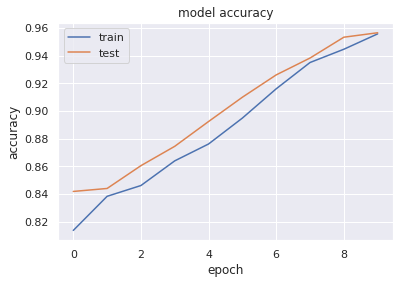

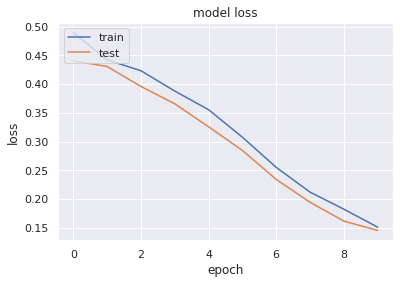

In [ ]:
plotPerformance(model_RNN)

# LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
model_lstm = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model_lstm.add(layers.Embedding(input_dim=num_words, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))

# Add a LSTM layer with 134 internal units.
model_lstm.add(layers.LSTM(134, dropout=0.1))

# Add a Dense layer with 10 units.
model_lstm.add(layers.Dense(1,activation='relu'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam',
                                            metrics=['accuracy'])

ltsm_model = model_lstm.fit(X_train, y_train, epochs=10, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/10
11/11 [==============================] - 8s 74ms/step - loss: 0.7380 - accuracy: 0.8372 - val_loss: 0.4518 - val_accuracy: 0.8443
Epoch 2/10
11/11 [==============================] - 0s 21ms/step - loss: 0.4381 - accuracy: 0.8427 - val_loss: 0.4156 - val_accuracy: 0.8425
Epoch 3/10
11/11 [==============================] - 0s 20ms/step - loss: 0.3996 - accuracy: 0.8421 - val_loss: 0.3681 - val_accuracy: 0.8425
Epoch 4/10
11/11 [==============================] - 0s 22ms/step - loss: 0.3378 - accuracy: 0.8518 - val_loss: 0.3103 - val_accuracy: 0.8662
Epoch 5/10
11/11 [==============================] - 0s 19ms/step - loss: 0.2971 - accuracy: 0.8649 - val_loss: 0.2957 - val_accuracy: 0.8605
Epoch 6/10
11/11 [==============================] - 0s 21ms/step - loss: 0.3012 - accuracy: 0.8566 - val_loss: 0.2523 - val_accuracy: 0.9032
Epoch 7/10
11/11 [==============================] - 0s 19ms/step - loss: 0.2765 - accuracy: 0.9024 - val_loss: 0.2507 - val_accuracy: 0.8985
Epoch 8/10
11

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 32, 100)           1393800   
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 134)               125960    
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 1)                 135       
Total params: 1,519,895
Trainable params: 126,095
Non-trainable params: 1,393,800
_________________________________________________________________


In [ ]:
print(classification_report(y_test, model_lstm.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2349
           1       0.94      0.80      0.86       439

    accuracy                           0.96      2788
   macro avg       0.95      0.90      0.92      2788
weighted avg       0.96      0.96      0.96      2788



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


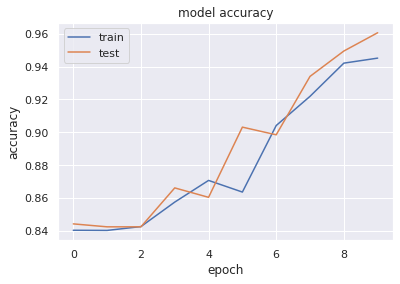

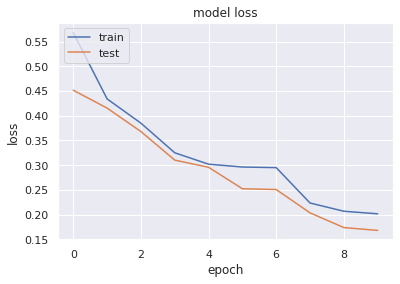

In [ ]:
plotPerformance(ltsm_model)

## Add Bidirectional

In [ ]:
model_lstm_bi = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model_lstm_bi.add(layers.Embedding(input_dim=num_words, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_len, trainable=False))

# Add a LSTM layer with 134 internal units.
model_lstm_bi.add(layers.Bidirectional(layers.LSTM(134, dropout=0.1)))

#model_lstm.add(layers.LSTM(134, dropout=0.1))

# Add a Dense layer with 10 units.
model_lstm_bi.add(layers.Dense(1,activation='relu'))
model_lstm_bi.compile(loss='binary_crossentropy', optimizer='rmsprop',
                                            metrics=['accuracy'])

Bi_LSTM_model = model_lstm_bi.fit(X_train, y_train, epochs=10, batch_size=1024, validation_data=(X_test, y_test))


Epoch 1/10
11/11 [==============================] - 5s 136ms/step - loss: 0.9269 - accuracy: 0.7426 - val_loss: 0.3921 - val_accuracy: 0.8418
Epoch 2/10
11/11 [==============================] - 0s 36ms/step - loss: 0.3831 - accuracy: 0.8364 - val_loss: 0.3384 - val_accuracy: 0.8702
Epoch 3/10
11/11 [==============================] - 0s 38ms/step - loss: 0.3131 - accuracy: 0.8578 - val_loss: 0.2721 - val_accuracy: 0.8684
Epoch 4/10
11/11 [==============================] - 0s 36ms/step - loss: 0.2782 - accuracy: 0.8740 - val_loss: 0.2803 - val_accuracy: 0.8745
Epoch 5/10
11/11 [==============================] - 0s 36ms/step - loss: 0.2750 - accuracy: 0.8872 - val_loss: 0.2228 - val_accuracy: 0.9035
Epoch 6/10
11/11 [==============================] - 0s 36ms/step - loss: 0.2208 - accuracy: 0.9049 - val_loss: 0.2106 - val_accuracy: 0.9093
Epoch 7/10
11/11 [==============================] - 0s 36ms/step - loss: 0.2037 - accuracy: 0.9296 - val_loss: 0.3532 - val_accuracy: 0.8691
Epoch 8/10
1

In [ ]:
model_lstm_bi.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_3 (ModuleWrap (None, 32, 100)           1393800   
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 268)               251920    
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 1)                 269       
Total params: 1,645,989
Trainable params: 252,189
Non-trainable params: 1,393,800
_________________________________________________________________


In [ ]:
print(classification_report(y_test, model_lstm_bi.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2349
           1       0.96      0.81      0.88       439

    accuracy                           0.96      2788
   macro avg       0.96      0.90      0.93      2788
weighted avg       0.96      0.96      0.96      2788



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


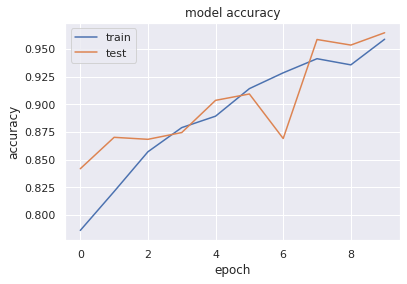

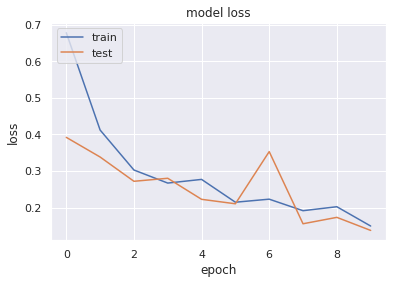

In [ ]:
plotPerformance(Bi_LSTM_model)